In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

In [17]:
data=pd.read_csv('data/headstart.csv')
len_before=len(data.index)
data=data.dropna(how='any',subset=['povrate60','mort_age59_related_postHS','census1960_pop'])
len_after=len(data.index)
print('Dropped',len_before-len_after,'lines that contain NaN.')

Dropped 26 lines that contain NaN.


In [136]:
# t is the threshold, k is a kernel function [0,1]->R, and b is the bandwidth
# Currently supports only 1D array
# Regression from left of t
def regr_sided(X,Y,t,k,b):
    # Dispose points outside bandwidth
    YL=Y[np.logical_and(t-b<X,X<t)]
    XL=X[np.logical_and(t-b<X,X<t)]
    
    # Calculate weights
    get_weight=np.vectorize(lambda x:k((np.abs((x-t)))/b))
    WL=get_weight(XL)

    # Reshape for lib use
    # Every data has a single feature
    XL=XL.values.reshape(-1,1)
    YL=YL.values.reshape(-1,1)
    
    # Create linear regression object
    regrL = linear_model.LinearRegression()
    
    # Train the model using the training sets
    regrL.fit(XL, YL, sample_weight=WL)
    
    return regrL

def regr_symmetric(X,Y,t,k,b):
    # Dispose points outside bandwidth
    XL=X[np.logical_and(t-b<X,X<t)]
    YL=Y[np.logical_and(t-b<X,X<t)]
    XR=X[np.logical_and(t<X,X<t+b)]
    YR=Y[np.logical_and(t<X,X<t+b)]
    
    # Calculate weights    
    get_weight=np.vectorize(lambda x:k(np.abs((x-threshold))/b))
    
    # Print weight
    print('Weights:')
    y=np.linspace(0,k(0),1000)
    x=t+0*y
    plt.plot(x,y,color='blue',linewidth=1)
    plt.plot(XL, get_weight(XL), color='purple', linewidth=2)
    plt.plot(XR, get_weight(XR), color='purple', linewidth=2)
    plt.show()
    
    regrL=regr_sided(X,Y,t,k,b)
    regrR=regr_sided(-X,Y,-t,k,b)
    
    # Make predictions using the testing set
    XL=XL.values.reshape(-1,1)
    XR=XR.values.reshape(-1,1)
    YL_pred = regrL.predict(XL)
    YR_pred = regrR.predict(np.negative(XR))
    EY_L = regrL.predict([[t]])[0][0]
    EY_R = regrR.predict(np.negative([[t]]))[0][0]
    
    # Output
    plt.scatter(XL, YL, s=0.2, color='black')
    plt.plot(XL, YL_pred, color='red', linewidth=2)
    plt.scatter(XR, YR, s=0.2, color='black')
    plt.plot(XR, YR_pred, color='red', linewidth=2)
    # Plot separating line
    y=np.linspace(0,max(EY_L,EY_R),1000)
    x=t+0*y
    plt.plot(x,y,color='blue',linewidth=1)
    plt.show()
    print('E[Y-]',EY_L)
    print('E[Y+]',EY_R)
    print('Estimated effect',EY_R-EY_L)
    
    return (regrL,regrR)

Weights:


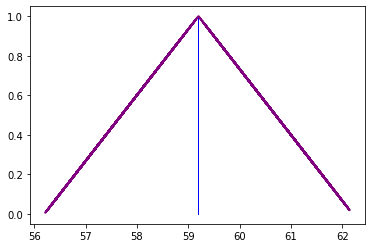

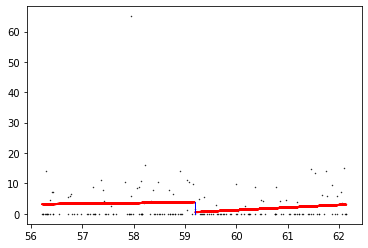

E[Y-] 3.7359632960497446
E[Y+] 0.49151239614237596
Estimated effect -3.2444508999073687


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

In [137]:
threshold=59.1984
def ker_tri(x):
    return 1-x
regr_symmetric(data['povrate60'],
               data['mort_age59_related_postHS'],
               threshold,
               ker_tri,
               3)

Weights:


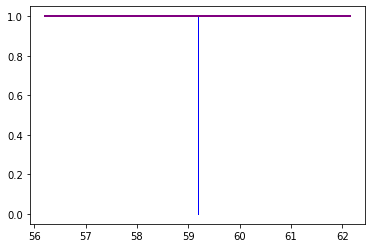

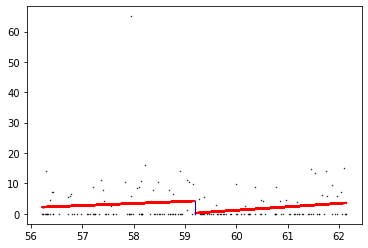

E[Y-] 4.181247634982988
E[Y+] 0.22113009048514698
Estimated effect -3.960117544497841


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

In [138]:
threshold=59.1984
def ker_rect(x):
    return 1 # Note that the constant here will not affect the result
regr_symmetric(data['povrate60'],
               data['mort_age59_related_postHS'],
               threshold,
               ker_rect,
               3)

In [146]:
def get_interval(X,Y,a,b):
    X1=X[np.logical_and(a<X,X<b)]
    Y1=Y[np.logical_and(a<X,X<b)]
def validator3(X,Y,k,b):
    n=30
    err_sum=0
    for test_case in range(n):
        #todo:select from [l+b,r] rather than [l,r]
        #select a random node
        i=X.index[np.random.choice(len(X.index))]
        x,y=X[i],Y[i]
        regr_model=regr_sided(X,Y,x,k,b)
        ey=regr_model.predict([[x]])[0][0]
        err_sum+=(ey-y)*(ey-y)
    return err_sum/n

validator3(data['povrate60'],data['mort_age59_related_postHS'],ker_rect,3)

8.803297155094635